#### Question 2 with SA

---
#### Some Hyperparmeteres

In [22]:
# Hyperparameters
MAXIMUM_WEIGHT = 529    #529
EACH_TYPE_ONE_ELEMENT = 0 #False
NO_UPDATE_TIMES = 10e4 #10e4

#### Load Data

In [23]:
import pandas as pd
List_of_Gear = pd.read_csv('List_of_gear.csv')

# Setup Row & Weapon name mapping
df = List_of_Gear.iloc[:,0]

# Setup Weight & Survival Points mapping
Weight_Map = List_of_Gear.iloc[:,2].to_numpy()
Survival_Points_Map = List_of_Gear.iloc[:,3].to_numpy()

#### Some methods

In [24]:
import numpy as np
def Weight_Mapping(Given_Array):
    Sum_of_weight = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_weight += Weight_Map[i]
    return Sum_of_weight

def Survival_Points_Mapping(Given_Array):
    Sum_of_Survival_Points = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_Survival_Points += Survival_Points_Map[i]
    # Extra Points
        ## YG1265 or Krieg 500 + Desert Eagle + tactical shield, survival points +25
    if(((Given_Array[7]==1)|(Given_Array[10]==1))&(Given_Array[5]==Given_Array[14]==1)):
        Sum_of_Survival_Points += 25
        ## shadow dagger + desert eagle, survival points +5
    if(Given_Array[0]==Given_Array[5]==1):
        Sum_of_Survival_Points += 5
        ## 228 Compact + AK-47 or M4A1, survival points +15
    if(((Given_Array[8]==1)|(Given_Array[9]==1))&(Given_Array[3]==1)):
        Sum_of_Survival_Points += 15
        ## Carry all three equipments, survial points +70
    if(Given_Array[12]==Given_Array[13]==Given_Array[14]==1):
        Sum_of_Survival_Points += 70
    return Sum_of_Survival_Points

def Check_Overweight(Given_Array):
    Weight = Weight_Mapping(Given_Array)
    if (Weight <= MAXIMUM_WEIGHT):
        return 0
    else:
        #print(f'Overweight!, weight={Weight}')
        return 1

def Check_Inventory_Requirement(Given_Array):
    Copy_with_padding = np.pad(Given_Array,
                               (0, 15-len(Given_Array)),
                               'constant',
                               constant_values=0)
    if((sum(Copy_with_padding[0:3])>0)
            &(sum(Copy_with_padding[3:6])>0)
            &(sum(Copy_with_padding[12:15])>0)):
        return 1
    else:
        return 0

def Generate_Single_Creature(Each_Type_One_Element):

    # The goal of the following part is to constraint the inventory bag to \
    # \"one item in each type" settings. However, it seems that\
    # \this settings were not required, thus the part was aborted.

    # if(Each_Type_One_Element==1):
    # # Except equipments, we can only choose one item in each type.
    # # I will set the initial choice of each items by utilizing np.eye matrix,\
    # # \then randomly select a row in order to represent the collection of items chosen.
    #     Knife = np.eye(3, dtype=int); Pistols = np.eye(3, dtype=int); Primary = np.eye(6, dtype=int);
    #     Selected_Knife = Randomly_Select_A_Row_from_Matrix(Knife)
    #     Selected_Pistols = Randomly_Select_A_Row_from_Matrix(Pistols)
    #     Selected_Primary = Randomly_Select_A_Row_from_Matrix(Primary)
    #     Equipments = np.random.randint(2, size=3, dtype=int)
    #     Items_in_Bag = np.concatenate((Selected_Knife, Selected_Pistols, Selected_Primary, Equipments))

    # else:
    Items_in_Bag = np.random.randint(2, size=15)

    # Conforming to the inventory bag settings of 'carry at least one knife,\
    # \one pistol and one equipment.
    while(Check_Inventory_Requirement(Items_in_Bag)==0):
        Items_in_Bag = np.random.randint(2, size=15)

    if Check_Overweight(Items_in_Bag)==0:
        return Items_in_Bag
    else:
        return Generate_Single_Creature(Each_Type_One_Element)   #Recursive Call till no overweight

In [25]:
# Generate Initial Temperature
rand_4pts = []
for i in range(4):
    Creature = Generate_Single_Creature(Each_Type_One_Element=0)
    rand_4pts.append(Survival_Points_Mapping(Creature))

init_temp = np.average(rand_4pts)

# Set Initial Weapons List
x = Generate_Single_Creature(Each_Type_One_Element=0)
SA = []

## Some Initializations
n = 2 # iterations
c = 0.5 # temperature reduction factor
no_update_times = 0
des_x = x
temp = init_temp
iters_sum = 0

while(no_update_times<=NO_UPDATE_TIMES):

    iter = 0

    while((iter<=n)&(no_update_times<=NO_UPDATE_TIMES)):
        # Compute current_state
        current_state = Survival_Points_Mapping(des_x)

        r = Generate_Single_Creature(Each_Type_One_Element=0)
        attempt_state = Survival_Points_Mapping(r)

        # Step 3 and Step 4
        del_f = attempt_state - current_state

        if del_f>0:
            #print(f'del_f:{del_f}')
            c = np.random.uniform(0, 1, 1)
            Prob_of_X_2 = np.exp(-del_f/(1*temp))
            #print(f' r = {r} , $P(X_2)$ = {Prob_of_X_2}')
            if Prob_of_X_2 > c:
                des_x = r
                #print(f'! assign new design (x) = {des_x}')
                SA.append(float(Survival_Points_Mapping(r)))
                current_state = attempt_state
                temp = c*temp
                no_update_times = 0
        else:
            no_update_times +=1

        iter += 1
        iters_sum += 1

print(f'   The best combination over all generations is: {des_x}'
      f'\n    with corresponding items: ', end=" ")
for i in range(len(des_x)):
    if des_x[i] == 1:
        print(f'{df[i]} +', end=" ")
print(f'\n    and maximum survival points: {current_state}'
        f', total weight: {Weight_Mapping(des_x):.1f}')

   The best combination over all generations is: [0 1 0 0 0 1 1 1 1 0 0 0 1 1 1]
    with correspond items:  Huntsman_Knife + Desert_Eagle_Magnum + Ingram_MAC-10_SMG + Leone_YG1265_Auto_Shotgun + M4A1_Carbine + Gas_Mask + Night-Vision_Goggle + Tactical_Shield + 
    and maximum survival points: 830, total weight: 525.2


#### FE plot

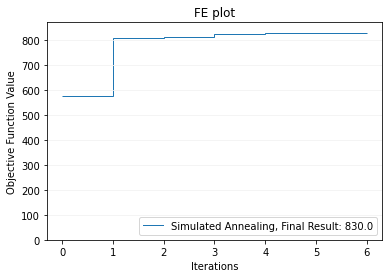

In [26]:
import matplotlib.pyplot as plt
plt.stairs(SA, label=f'Simulated Annealing, Final Result: {SA[-1]}', baseline=None)

plt.xlabel('Iterations')
plt.ylabel('Objective Function Value')
plt.title('FE plot')
# plt.xlim()
# plt.ylim()
plt.grid(axis='y', color='0.95')

plt.legend(loc=4)

plt.show()